#### Дата начала целевой недели

In [4]:
start_date = input("Дата начала периода yyyy-mm-dd (input and press enter) ")

Дата начала периода yyyy-mm-dd (input and press enter)  2021-05-04


In [5]:
startdate = start_date.replace('-','')

In [6]:
import cx_Oracle
import pandas as pd
import numpy as np
#import joblib
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [17]:
def make_bin(df, field, top_field, nbins = 20):
    df = df.sort_values(by=[field], ascending=False)
    #print(df)
    l = 0
    k = 1
    
    coef = len(df) // nbins
    df_new = df[0:coef]
    df_new[top_field] = 1
    
    for i in range(1,nbins):
        k += 1
        l += coef
        df_part = df[l:coef+l]
        df_part[top_field] = k
        df_new = pd.concat([df_new, df_part])
    
    df_part = df[coef+l:len(df)]
    df_part[top_field] = k
    df_new = pd.concat([df_new, df_part])
        
    return df_new

### Таргет

In [18]:
#target = pd.read_sql('select * from ci_common.lil_uplift_train_startdate_responce'.replace('startdate',startdate), conn)
target = pd.read_csv('uplift_train_startdate_responce.csv',index_col=0)

In [19]:
target.sample(5)

,PLAYER_GATE_ID,CELL_PACKAGE_SK,TREATMENT_IND,LEVEL1,GROUP_SEGMENT,LTV,RESPONCE_IND,RESPONCE_SUM
4251,5276143099900,1988131,0,Розница,Активные 1 мес.,1131,0,0
13913,8948261086600,1988522,0,Федеральные сети,Активные 1 мес.,223,0,0
46495,7199061366600,1988515,1,Федеральные сети,Активные 1 мес.,516,0,0
30201,6103297610100,1988102,1,Розница,Активные 1 мес.,761,0,0
11801,4761551762700,1988541,1,Федеральные сети,Активные 1 мес.,1276,0,0


### Описание данных
* player_gate_id - идентификатор покупателя
* cell_package_sk - идентификатор рассылки на участника
* treatment_ind - идентификатор целевой/контрольной группы (1/0 соотв)
* level_1 - агрегированый канал продаж
* group_segment - Жизненная группировка
* LTV - (это LT) -  Дней с первой покупки
* Responce_ind - Покупка после СМС
* Responce_sum - сумма покупки после СМС

### Проверяем максимальное число рассылок на человека. Если больше 1, нужно сагрегировать до игрока либо перейти к PLAYER_CELL_ID

In [12]:
target[['CELL_PACKAGE_SK', 'PLAYER_GATE_ID']].groupby(['PLAYER_GATE_ID']).count()['CELL_PACKAGE_SK'].max()

1

### Активность за 4 недели

In [13]:
#activity.read_csv('uplift_train_startdate_pl_activity',index_col=0)
activity = pd.read_csv('uplift_train_startdate_pl_activity.csv',index_col=0)

In [20]:
activity.set_index(['PLAYER_GATE_ID', 'WEEK_N']).sample(7).T

PLAYER_GATE_ID,3834513376500,9563322748400,9279339313700,6583424781500,2870932210600,6134836577900,3650581905700
WEEK_N,2.0,4.0,3.0,2.0,3.0,3.0,4.0
SALE_SUM,300.0,300.0,100.0,200.0,1400.0,200.0,200.0
WIN_SUM,150.0,200.0,100.0,NaN,602.0,150.0,100.0
WIN_CNT,1.0,2.0,1.0,0.0,6.0,1.0,1.0
TICKET_CNT,2.0,3.0,1.0,2.0,14.0,2.0,2.0
BINGO_SALES,0.0,300.0,100.0,200.0,1400.0,200.0,200.0
MOMENT_SALES,0.0,0.0,0.0,0.0,0.0,0.0,0.0
QUICK_SALES,300.0,0.0,0.0,0.0,0.0,0.0,0.0
NUMBER_SALES,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AR_SALES,300.0,300.0,0.0,0.0,0.0,0.0,200.0


In [21]:
activity = activity[activity.WEEK_N.notna()]

In [22]:
activity['WIN_SUM_SHARE'] = activity['WIN_SUM']/activity['SALE_SUM']
activity['WIN_TICKETS_SHARE'] = activity['WIN_CNT']/activity['TICKET_CNT']

activity['BINGO_SHARE'] = activity['BINGO_SALES']/activity['SALE_SUM']
activity['MOMENT_SHARE'] = activity['MOMENT_SALES']/activity['SALE_SUM']
activity['QUICK_SHARE'] = activity['QUICK_SALES']/activity['SALE_SUM']
activity['NUMBER_SHARE'] = activity['NUMBER_SALES']/activity['SALE_SUM']

activity['AR_SHARE'] = activity['AR_SALES']/activity['SALE_SUM']
activity['FS_SHARE'] = activity['FS_SALES']/activity['SALE_SUM']

In [23]:
activity['WEEK_N'] = activity['WEEK_N'].astype(int).astype(str)

In [24]:
activity.sample(5)

,PLAYER_GATE_ID,WEEK_N,SALE_SUM,WIN_SUM,WIN_CNT,TICKET_CNT,BINGO_SALES,MOMENT_SALES,QUICK_SALES,NUMBER_SALES,AR_SALES,FS_SALES,SITE_SALES,MOBSITE_SALES,MOBAPP_SALES,WIN_SUM_SHARE,WIN_TICKETS_SHARE,BINGO_SHARE,MOMENT_SHARE,QUICK_SHARE,NUMBER_SHARE,AR_SHARE,FS_SHARE
20427,4777620306900,2,100.0,100.0,1,1,100,0,0,0,100,0,0,0,0,1.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0
15153,2469698837900,2,100.0,100.0,1,1,100,0,0,0,0,100,0,0,0,1.000000,1.0,1.0,0.0,0.0,0.0,0.0,1.0
49806,8867939184000,1,100.0,NaN,0,1,100,0,0,0,0,100,0,0,0,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3311,5325417165700,4,450.0,114.0,1,5,450,0,0,0,0,450,0,0,0,0.253333,0.2,1.0,0.0,0.0,0.0,0.0,1.0
30459,4863205081600,4,400.0,1100.0,2,4,400,0,0,0,0,400,0,0,0,2.750000,0.5,1.0,0.0,0.0,0.0,0.0,1.0


### Описание данных
* Week_N - Недель назад 
* Sale_sum - Сумма продаж
* Win_sum - Сумма выигрышей
* Ticket_cnt - Количество купленных билетов
* Bingo_sale - продажи Бинго лотерей
* Moment_sales - продажи Моментальных лотерей
* Quick_sales - продажи быстрых лотерей
* Number_sales - продажи числовых лотерей
* AR_SALES - продажи в розничных точках
* FS_SALES - продажи в Федеральных сетях
* Site_sales - продажи на сайте
* Mobsite_sales -Продажи на мобильном сайте
* Mobapp_sales - продажи в мобильном приложении

### История откликов за 6 месяцев

In [25]:
resp_hist = pd.read_csv('uplift_train_startdate_call_history.csv')

In [26]:
resp_hist.sample(10)

,Unnamed: 0,PLAYER_GATE_ID,MONTH_N,TREATMENT_SHR,RESPONCE_SHR,DAYS_FROM_LAST_SMS
66779,66779,7154106697100,2,1,0,6
52891,52891,5290425945100,1,1,1,6
36053,36053,5562325520800,3,1,0,13
52630,52630,3269811481300,3,1,1,6
98691,98691,1362396312100,1,1,0,6
68864,68864,5550580586300,2,1,0,4
90433,90433,4831412868800,3,1,0,6
8012,8012,9209254976300,3,1,0,6
12258,12258,5521117885100,1,1,0,5
28680,28680,4750737581600,1,1,1,13


In [27]:
resp_hist.dropna(inplace = True)

In [28]:
rh_new = resp_hist[['PLAYER_GATE_ID', 'TREATMENT_SHR','RESPONCE_SHR', 'MONTH_N']].groupby(['PLAYER_GATE_ID', 'MONTH_N']).mean().reset_index()

In [29]:
rh_new.columns = ['PLAYER_GATE_ID', 'MONTH_N', 'TREATMENT_HIST_SHR', 'RESPONCE_HIST_SHR']

In [30]:
rh_new = pd.merge(rh_new,
         resp_hist[['MONTH_N', 'PLAYER_GATE_ID', 'TREATMENT_SHR']].groupby(['PLAYER_GATE_ID','MONTH_N']).count().reset_index(),
               on = ['PLAYER_GATE_ID','MONTH_N'],
               how = 'inner'
              )

In [31]:
rh_new.columns = ['PLAYER_GATE_ID', 'M', 'TREATMENT_HIST_SHR', 'RESPONCE_HIST_SHR', 'CAMPAIGN_CNT']

In [32]:
rh_new['M'] = rh_new['M'].astype(int).astype(str)

In [33]:
rh_new = rh_new.groupby(['PLAYER_GATE_ID','M']).sum().unstack()
rh_new.columns = ['_'.join(col).strip() for col in rh_new.columns.values]

In [34]:
rh_new = rh_new.fillna(0)

rh_new[['CAMPAIGN_CNT_1', 'CAMPAIGN_CNT_2', 'CAMPAIGN_CNT_3']] = rh_new[['CAMPAIGN_CNT_1', 'CAMPAIGN_CNT_2', 'CAMPAIGN_CNT_3']].fillna(0)

In [35]:
rh_new = pd.merge(resp_hist[['PLAYER_GATE_ID', 'DAYS_FROM_LAST_SMS']].groupby(['PLAYER_GATE_ID']).min().reset_index(),
               rh_new.reset_index(),
               on = 'PLAYER_GATE_ID',
               how = 'inner')

### Собираем всё в 1 таблицу и создаём фичи

In [36]:
data = activity[['WIN_CNT', 'MOMENT_SALES',
       'QUICK_SALES', 'WEEK_N', 'AR_SALES',
       'BINGO_SALES', 
       'TICKET_CNT', 'NUMBER_SALES',
       'FS_SALES', 'SALE_SUM', 'WIN_SUM', 'PLAYER_GATE_ID'
              ,'WIN_SUM_SHARE', 'WIN_TICKETS_SHARE', 'BINGO_SHARE', 'MOMENT_SHARE',
       'QUICK_SHARE', 'NUMBER_SHARE', 'AR_SHARE', 'FS_SHARE']].groupby(['PLAYER_GATE_ID','WEEK_N']).sum().unstack()

In [37]:
data.columns = ['_'.join(col).strip() for col in data.columns.values]

In [38]:
target['ar_ind']=0
target.loc[target['LEVEL1']=='Розница','ar_ind']=1

In [39]:
target['GROUP_SEGMENT'].value_counts()

Активные 1 мес.          47129
ВИП - Активные 1 мес.     1661
Отток 2-3 мес.            1210
Name: GROUP_SEGMENT, dtype: int64

In [40]:
target['vip_ind']=0
target.loc[target['GROUP_SEGMENT']=='ВИП - Смешанные','vip_ind']=1
target.loc[target['GROUP_SEGMENT']=='ВИП - Активные 1 мес.','vip_ind']=1

In [41]:
target['vip_ind'].value_counts()

0    48339
1     1661
Name: vip_ind, dtype: int64

In [42]:
data = pd.merge(target[['PLAYER_GATE_ID', 'TREATMENT_IND', 'RESPONCE_SUM', 'ar_ind', 'vip_ind', 'LTV']],
                data,
                on = 'PLAYER_GATE_ID',
                how = 'left')

In [43]:
data = pd.merge(data,rh_new,on=['PLAYER_GATE_ID'],how='inner')

In [44]:
data.set_index(['PLAYER_GATE_ID', 'TREATMENT_IND', 'RESPONCE_SUM', 'ar_ind', 'vip_ind','LTV'],inplace = True)

In [45]:
data.fillna(0, inplace = True)

In [46]:
data.replace(0,0.00001,inplace = True)

In [47]:
data['RESPONCE_HIST_SHR_AVG'] = data[['RESPONCE_HIST_SHR_1', 'RESPONCE_HIST_SHR_2', 'RESPONCE_HIST_SHR_3']].mean(axis = 1)

data['RESPONCE_HIST_SHR_TREND'] = data['RESPONCE_HIST_SHR_1']/data['RESPONCE_HIST_SHR_AVG']

data['TREATMENT_HIST_SHR_AVG'] = data[['TREATMENT_HIST_SHR_1', 'TREATMENT_HIST_SHR_2', 'TREATMENT_HIST_SHR_3']].mean(axis = 1)

data['TREATMENT_HIST_SHR_TREND'] = data['TREATMENT_HIST_SHR_1']/data['TREATMENT_HIST_SHR_AVG']

data['CAMPAIGN_CNT_SUM'] = data[['CAMPAIGN_CNT_1', 'CAMPAIGN_CNT_2', 'CAMPAIGN_CNT_3']].sum(axis = 1)

data['CAMPAIGN_CNT_MAX'] = data[['CAMPAIGN_CNT_1', 'CAMPAIGN_CNT_2', 'CAMPAIGN_CNT_3']].max(axis = 1)

data['CAMPAIGN_CNT_AVG'] = data[['CAMPAIGN_CNT_1', 'CAMPAIGN_CNT_2', 'CAMPAIGN_CNT_3']].mean(axis = 1)

data['CAMPAIGN_CNT_TREND'] = data['CAMPAIGN_CNT_1']/data['CAMPAIGN_CNT_AVG']

In [48]:
def genfeat(data
           , var
           , start = 1
           , end_w = 4
           , null_value = 0.00001
          ):
    columns = []
    columns_was = []
    
    #cnt null
    data[var+'_cnt_null'] = 0
    
    # calculate min, mean, max, range
    data[var+'_min'] = data[[var+'_1', var+'_2', var+'_3', var+'_4']].min(axis = 1)
    data[var+'_max'] = data[[var+'_1', var+'_2', var+'_3', var+'_4']].max(axis = 1)
    data[var+'_mean'] = data[[var+'_1', var+'_2', var+'_3', var+'_4']].mean(axis = 1)
    data[var+'_range'] = data[var+'_max']-data[var+'_min'] 
    
    columns.append(var+'_min')
    columns.append(var+'_max')
    columns.append(var+'_mean')
    columns.append(var+'_range')
    
    #calculate ratio to avg
    for i in range(start, end_w+1):
        data[var+str(i)+'_to_avg'] = data[str(var)+'_'+str(i)] / data[var+'_mean']
        data.loc[data[var+'_mean']==null_value, var+str(i)+'_to_avg'] = null_value
        columns.append(var+str(i)+'_to_avg')
    
    #calculate div minus nulls for weeks
    for i in range(start, end_w):
        data[var+'_'+str(i)+'/'+str(i+1)] =  data[str(var)+'_'+str(i+1)] / data[str(var)+'_'+str(i)]
        data[var+'_'+str(i)+'-'+str(i+1)] = data[str(var)+'_'+str(i+1)] - data[str(var)+'_'+str(i)]
        data[var+'_cnt_null'] = data[var+'_cnt_null'] + (data[str(var)+'_'+str(i)] == null_value).astype(int)
        
        columns.append(var+'_'+str(i))
        columns.append(var+'_'+str(i)+'/'+str(i+1))
        columns.append(var+'_'+str(i)+'-'+str(i+1))
        
        columns_was.append(var+'_'+str(i))
    
    #add last day (because range does not include end day)
    data[var+'_cnt_null'] = data[var+'_cnt_null'] + (data[str(var)+'_'+str(end_w)] == null_value).astype(int)
    
    columns.append(var+'_cnt_null')
    columns.append(var+'_'+str(end_w))
    columns_was.append(var+'_'+str(end_w))
           
     #trend in last 4 weeks   
    for i in range(start, end_w-1):
        data[var+'_'+str(i+2)+'trend'+str(i)+str(i+1)+str(i+2)] =  data[str(var)+'_'+str(i+2)] / ((data[str(var)+'_'+str(i)] + data[str(var)+'_'+str(i+1)] + data[str(var)+'_'+str(i+2)])/3)
        columns.append(var+'_'+str(i+2)+'trend'+str(i)+str(i+1)+str(i+2))
        
    return data

In [49]:
for i in ['WIN_CNT', 'MOMENT_SALES', 'QUICK_SALES', 'AR_SALES', 'BINGO_SALES', 
       'TICKET_CNT', 'NUMBER_SALES', 'FS_SALES', 'SALE_SUM', 'WIN_SUM',
      'WIN_SUM_SHARE', 'WIN_TICKETS_SHARE', 'BINGO_SHARE', 'MOMENT_SHARE',
       'QUICK_SHARE', 'NUMBER_SHARE', 'AR_SHARE', 'FS_SHARE']:
    genfeat(data, i)

In [50]:
data = round(data,2)

In [51]:
data.fillna(0, inplace = True)

In [52]:
data.reset_index(inplace = True)

In [53]:
data.set_index(['PLAYER_GATE_ID']).sample(7).T

PLAYER_GATE_ID,8854574212300,9617032947700,6100867029500,4820947604900,4966141151400,5332303023200,6131461015600
TREATMENT_IND,1.00,1.00,1.00,1.00,0.00,1.00,0.00
RESPONCE_SUM,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ar_ind,0.00,1.00,0.00,0.00,1.00,0.00,1.00
vip_ind,0.00,0.00,0.00,0.00,0.00,0.00,0.00
LTV,192.00,80.00,764.00,1446.00,1253.00,1029.00,698.00
WIN_CNT_1,0.00,0.00,0.00,0.00,0.00,0.00,0.00
WIN_CNT_2,0.00,0.00,0.00,0.00,0.00,0.00,0.00
WIN_CNT_3,0.00,0.00,0.00,0.00,0.00,0.00,2.00
WIN_CNT_4,0.00,0.00,0.00,0.00,3.00,0.00,0.00
MOMENT_SALES_1,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Создаём таргет

In [54]:
data['CLIENT_TYPE'] = 'TR'

In [55]:
data.loc[(data['RESPONCE_SUM']<1)&(data['TREATMENT_IND']==0), 'CLIENT_TYPE'] = 'CN'
data.loc[(data['RESPONCE_SUM']>0)&(data['TREATMENT_IND']==0), 'CLIENT_TYPE'] = 'CR'
data.loc[(data['RESPONCE_SUM']<1)&(data['TREATMENT_IND']==1), 'CLIENT_TYPE'] = 'TN'

In [56]:
data['CLIENT_TYPE'].value_counts()

TN    11536
TR     2819
CN     1336
CR      300
Name: CLIENT_TYPE, dtype: int64

### Обучаем модель

In [57]:
data.set_index(['PLAYER_GATE_ID', 'TREATMENT_IND', 'RESPONCE_SUM'],inplace = True)

In [58]:
features = ['RESPONCE_HIST_SHR_AVG'
,'SALE_SUM_cnt_null'
,'TICKET_CNT_cnt_null'
,'TICKET_CNT_1'
,'LTV'
,'RESPONCE_HIST_SHR_2'
,'RESPONCE_HIST_SHR_1'
,'BINGO_SHARE_max'
,'TICKET_CNT2_to_avg'
,'SALE_SUM2_to_avg'
,'BINGO_SHARE_mean'
,'CAMPAIGN_CNT_3'
,'RESPONCE_HIST_SHR_3'
,'SALE_SUM1_to_avg'
,'NUMBER_SALES_range'
,'SALE_SUM_1'
,'NUMBER_SHARE_max'
,'CAMPAIGN_CNT_TREND'
,'TREATMENT_HIST_SHR_AVG'
,'WIN_SUM1_to_avg'
,'TREATMENT_HIST_SHR_3'
,'CAMPAIGN_CNT_AVG'
,'WIN_CNT_1'
,'SALE_SUM_2'
,'CAMPAIGN_CNT_SUM'
,'BINGO_SHARE_range'
,'NUMBER_SALES_max'
,'TREATMENT_HIST_SHR_2'
,'TICKET_CNT_2'
,'TICKET_CNT_min'
,'WIN_SUM_SHARE_2'
,'WIN_SUM_mean'
,'DAYS_FROM_LAST_SMS'
,'TICKET_CNT1_to_avg'

]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(data[features],
                                                    data['CLIENT_TYPE'],
                                                    test_size=0.4,
                                                    random_state=123)

In [60]:
eval_dataset = Pool(X_test,y_test)

In [61]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
cw = dict(zip(classes, weights))

In [62]:
clf = CatBoostClassifier(iterations=150
                                  , depth=6
                                  , loss_function='MultiClass'
                                  , learning_rate = 0.05
                                  , l2_leaf_reg = 3
                                  , random_state=123
                                  , auto_class_weights= 'Balanced'
                                ,silent = True)

In [63]:
clf = clf.fit(X_train, y_train, eval_set = eval_dataset)

### LightGBM part

In [64]:
clf2=lgb.LGBMClassifier(class_weight = 'balanced', learning_rate = 0.05, max_depth=6 )

In [65]:
#Converting the dataset in proper LGB format
d_train=lgb.Dataset(X_train, label=y_train.reset_index(drop = True).replace(['TN','TR','CN','CR'],[0,1,2,3]))

In [66]:
#training the model
clf2.fit(X = X_train, y = y_train, )  #training the model on 100 epocs

LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=6)

In [67]:
#prediction on the test dataset
y_pred_1=clf2.predict(X_test)

In [68]:
y_pred_1

array(['TR', 'TR', 'CN', ..., 'CR', 'CR', 'TN'], dtype=object)

In [70]:
y_pred_1=clf2.predict(X_test)
y_pred_1 = [np.argmax(line) for line in y_pred_1]
y_pred_1_pd = pd.DataFrame(y_pred_1)
y_pred_1_pd = y_pred_1_pd.replace([0,1,2,3],['TN','TR','CN','CR'])

In [71]:
y_pred_1_pd.head()

,0
0,TN
1,TN
2,TN
3,TN
4,TN


### Смотрим результаты

In [72]:
pd.DataFrame({'feature_name': clf.feature_names_,
              'feature_score': clf.feature_importances_
             }).sort_values('feature_score', ascending=False).reset_index(drop=True)

,feature_name,feature_score
0,RESPONCE_HIST_SHR_AVG,19.711489
1,LTV,10.910113
2,RESPONCE_HIST_SHR_1,7.723527
3,RESPONCE_HIST_SHR_3,6.983795
4,RESPONCE_HIST_SHR_2,5.020142
5,TREATMENT_HIST_SHR_3,4.980709
6,CAMPAIGN_CNT_TREND,4.454589
7,TREATMENT_HIST_SHR_AVG,3.585720
8,NUMBER_SHARE_max,3.171377
9,BINGO_SHARE_max,3.107676


In [73]:
clf.best_score_

{'learn': {'MultiClass': 1.2348442221877298},
 'validation': {'MultiClass': 1.3554557905877245}}

In [74]:
print(' Catboost ', '\n',
' Weighted F1 Train:', round(f1_score(y_train, clf.predict(X_train), average="weighted"),3), '\n',
'Weighted F1 Test:', round(f1_score(y_test, clf.predict(X_test), average="weighted"),3), '\n','\n',
     
'Weighted Precision Train:', round(precision_score(y_train, clf.predict(X_train), average="weighted"),3), '\n',
'Weighted Precision Test:', round(precision_score(y_test, clf.predict(X_test), average="weighted"),3), '\n','\n',
     
'Weighted Recall Train:', round(recall_score(y_train, clf.predict(X_train), average="weighted"),3), '\n',
'Weighted Recall Test:', round(recall_score(y_test, clf.predict(X_test), average="weighted"),3)
     )

 Catboost  
  Weighted F1 Train: 0.503 
 Weighted F1 Test: 0.487 
 
 Weighted Precision Train: 0.638 
 Weighted Precision Test: 0.614 
 
 Weighted Recall Train: 0.436 
 Weighted Recall Test: 0.419


In [75]:
print(' LGBMClassifier ', '\n',
' Weighted F1 Train:', round(f1_score(y_train, clf2.predict(X_train), average="weighted"),3), '\n',
'Weighted F1 Test:', round(f1_score(y_test, clf2.predict(X_test), average="weighted"),3), '\n','\n',
     
'Weighted Precision Train:', round(precision_score(y_train, clf2.predict(X_train), average="weighted"),3), '\n',
'Weighted Precision Test:', round(precision_score(y_test, clf2.predict(X_test), average="weighted"),3), '\n','\n',
     
'Weighted Recall Train:', round(recall_score(y_train, clf2.predict(X_train), average="weighted"),3), '\n',
'Weighted Recall Test:', round(recall_score(y_test, clf2.predict(X_test), average="weighted"),3)
     )

 LGBMClassifier  
  Weighted F1 Train: 0.525 
 Weighted F1 Test: 0.459 
 
 Weighted Precision Train: 0.687 
 Weighted Precision Test: 0.612 
 
 Weighted Recall Train: 0.467 
 Weighted Recall Test: 0.39


## Classification report

In [76]:
print(classification_report(y_test, clf2.predict(X_test)))

              precision    recall  f1-score   support

          CN       0.09      0.26      0.13       547
          CR       0.02      0.18      0.04       121
          TN       0.77      0.42      0.55      4600
          TR       0.27      0.33      0.30      1129

    accuracy                           0.39      6397
   macro avg       0.29      0.30      0.26      6397
weighted avg       0.61      0.39      0.46      6397



### Получаем предсказания

In [77]:
preds_proba = clf.predict_proba(X_test)
#preds_proba = clf.predict_proba(data[features])

#### UPLIFT = TR + CN - TN - CR

#### Проверяем что классы в порядке ['CN', 'CR', 'TN', 'TR']. Если нет, нужно скорректировать расчёт аплифта в uplift_pred

In [78]:
clf.classes_

array(['CN', 'CR', 'TN', 'TR'], dtype=object)

In [79]:
uplift_pred = []

In [80]:
for i in preds_proba:
    uplift_pred.append(i[3]+i[0]-i[2]-i[1])

In [81]:
res = y_test.reset_index()
#res = data.reset_index()[y_train.reset_index().columns]
res['uplift_pred'] = uplift_pred

### График доходности

In [82]:
res = pd.merge(res
              ,data.reset_index()[['PLAYER_GATE_ID', 'ar_ind']]
              ,on = ['PLAYER_GATE_ID']
              ,how = 'left')

In [83]:
res['RESPONCE_IND']=0
res.loc[res['RESPONCE_SUM']>0,'RESPONCE_IND']=1

In [84]:
ar = res[res['ar_ind']==1][['PLAYER_GATE_ID', 'TREATMENT_IND', 'RESPONCE_SUM', 'RESPONCE_IND', 'CLIENT_TYPE', 'uplift_pred', 'ar_ind']]
fs = res[res['ar_ind']==0][['PLAYER_GATE_ID', 'TREATMENT_IND', 'RESPONCE_SUM', 'RESPONCE_IND', 'CLIENT_TYPE', 'uplift_pred', 'ar_ind']]

In [85]:
ar = make_bin(ar, 'uplift_pred', 'top',100)
fs = make_bin(fs, 'uplift_pred', 'top',100)

In [86]:
cum_delta_fs = []
cum_sales_fs = []
cum_n_fs = []
cum_response_fs = []

for i in np.arange(1,101):
    cum_delta_fs.append(fs[(fs.TREATMENT_IND==1)&(fs.top<=i)]['RESPONCE_IND'].mean()-fs[(fs.TREATMENT_IND==0)&(fs.top<=i)]['RESPONCE_IND'].mean())

for i in np.arange(1,101):
    cum_sales_fs.append(fs[(fs['TREATMENT_IND']==1)&(fs.top<=i)]['RESPONCE_SUM'].replace(0,np.nan).mean())
    
for i in np.arange(1,101):
    cum_response_fs.append(fs[(fs.TREATMENT_IND==1)&(fs.top<=i)]['RESPONCE_IND'].mean())
    
for i in np.arange(1,101):
    cum_n_fs.append(len(fs[(fs['TREATMENT_IND']==1)&(fs.top<=i)]))

fs_profit = pd.DataFrame({
                          'top':np.arange(1,101),
                          'n':cum_n_fs,
                          'cum_delta':cum_delta_fs,
                          'cum_sales':cum_sales_fs,
                          'cum_response':cum_response_fs
                         })

fs_profit['profit'] = (fs_profit['n']*fs_profit['cum_sales']*fs_profit['cum_delta']*.22-2*fs_profit['n'])#/(fs_profit['n']*(fs_profit['cum_delta']+fs_profit['cum_response']))

In [87]:
cum_delta_ar = []
cum_sales_ar = []
cum_n_ar = []
cum_response_ar = []

for i in np.arange(1,101):
    cum_delta_ar.append(ar[(ar.TREATMENT_IND==1)&(ar.top<=i)]['RESPONCE_IND'].mean()-ar[(ar.TREATMENT_IND==0)&(ar.top<=i)]['RESPONCE_IND'].mean())

for i in np.arange(1,101):
    cum_sales_ar.append(ar[(ar['TREATMENT_IND']==1)&(ar.top<=i)]['RESPONCE_SUM'].replace(0,np.nan).mean())
    
for i in np.arange(1,101):
    cum_response_ar.append(ar[(ar.TREATMENT_IND==1)&(ar.top<=i)]['RESPONCE_IND'].mean())
    
for i in np.arange(1,101):
    cum_n_ar.append(len(ar[(ar['TREATMENT_IND']==1)&(ar.top<=i)]))

ar_profit = pd.DataFrame({
                          'top':np.arange(1,101),
                          'n':cum_n_ar,
                          'cum_delta':cum_delta_ar,
                          'cum_sales':cum_sales_ar,
                          'cum_response':cum_response_ar
                         })

ar_profit['profit'] = (ar_profit['n']*ar_profit['cum_sales']*ar_profit['cum_delta']*.22-2*ar_profit['n'])

In [88]:
ar_top_threshold = int(ar_profit[ar_profit['profit']==ar_profit['profit'].max()]['top'])
fs_top_threshold = int(fs_profit[fs_profit['profit']==fs_profit['profit'].max()]['top'])

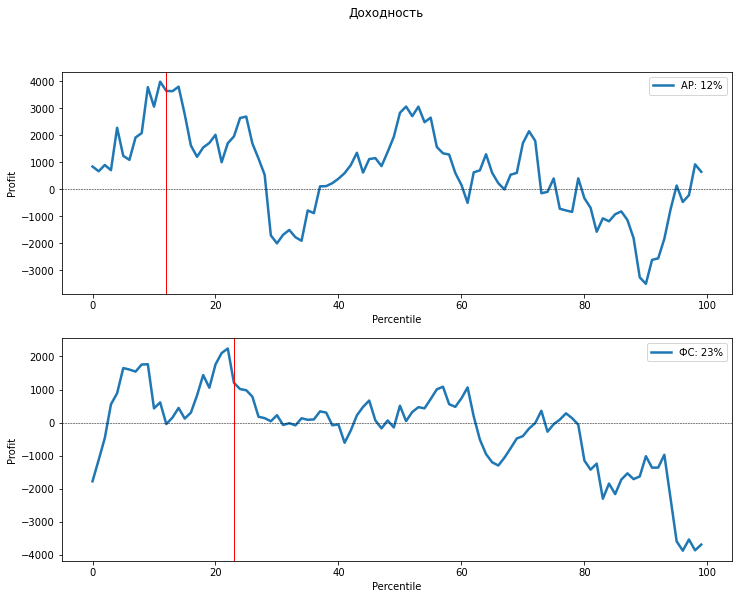

In [90]:
fig, (ax1, ax2) = plt.subplots(2,figsize=(12,9))

fig.suptitle('Доходность')
ax1.plot(ar_profit['profit'],linewidth = 2.5)
ax1.axvline(x=ar_top_threshold,linewidth = 1,color='red')
ax1.axhline(y=0,linewidth = .5,linestyle='dashed',color='black')

ax1.legend(["АР: "+ str(round(ar_top_threshold,2))+'%'])
ax1.set_xlabel('Percentile')
ax1.set_ylabel('Profit')

ax2.plot(fs_profit['profit'],linewidth = 2.5)
ax2.axvline(x=fs_top_threshold,linewidth = 1,color='red')
ax2.axhline(y=0,linewidth = .5,linestyle='dashed',color='black')

ax2.legend(["ФС: "+ str(round(fs_top_threshold,2))+'%'])
ax2.set_xlabel('Percentile')
ax2.set_ylabel('Profit')

plt.savefig('add_sales_validation_data_'+start_date)

### Сохраняем модель

In [109]:
joblib.dump(clf, 'uplift_model_'+startdate+'_try_with_3m_resp_hist_only.sav')

['uplift_model_20210524_try_with_3m_resp_hist_only.sav']